<a href="https://colab.research.google.com/github/abmmatthew/dashboards/blob/master/Homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Case 1. Real estate prices in NYC
Consider rolling sales data as in the LAB 2
The Department of Finance’s Rolling Sales files lists properties that sold in the last twelve-month period in New York City for all tax classes. These files include:

    sale date
    the address, zip code and tax borough, block and lot (BBL)
    building type;
    square footage;
    the price
    other characteristics

Focus on the Staten Island in 2019 and ask a question:
which characteristic of the house would be the best predictor for its price?

And implement such prediction using linear regression.


In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import math
import os
#import seaborn as sns #for styling the plots
import warnings
import urllib.request
%matplotlib inline

In [2]:
#load the house sales data from Staten Island
REStaten=pd.read_excel('https://github.com/CUSP2020PUI/Data/raw/master/2019statenisland.xlsx', skiprows=4, engine='openpyxl')

In [3]:
#fix column names, excluding \n
REStaten.columns = [col.replace('\n','').replace(' ','_') for col in REStaten.columns]
REStaten.head(5)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AS_OF_FINAL_ROLL_18/19,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AS_OF_FINAL_ROLL_18/19,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,5,ANNADALE,01 ONE FAMILY DWELLINGS,1,5391,13,NaN,A5,4716 AMBOY ROAD,NaN,...,1.0,0.0,1.0,1871.0,910.0,2002.0,1,A5,0,2019-07-10
1,5,ANNADALE,01 ONE FAMILY DWELLINGS,1,5393,29,NaN,A1,21 FINGAL STREET,NaN,...,1.0,0.0,1.0,9000.0,3540.0,1985.0,1,A1,1650000,2019-03-14
2,5,ANNADALE,01 ONE FAMILY DWELLINGS,1,5395,23,NaN,A1,525 SYCAMORE STREET,NaN,...,1.0,0.0,1.0,10000.0,2848.0,1980.0,1,A1,775000,2019-12-13
3,5,ANNADALE,01 ONE FAMILY DWELLINGS,1,5398,20,NaN,A1,1468 ARDEN AVENUE,NaN,...,1.0,0.0,1.0,5000.0,2200.0,1940.0,1,A1,685000,2019-04-15
4,5,ANNADALE,01 ONE FAMILY DWELLINGS,1,5399,15,NaN,A2,2 SANDBORN STREET,NaN,...,1.0,0.0,1.0,4845.0,880.0,1950.0,1,A2,0,2019-01-24


In [4]:
#subset dataframe by selecting columns we're going to use
selectedNames = ['BOROUGH','BLOCK','LOT', 'BUILDING_CLASS_CATEGORY', 'ADDRESS', 'ZIP_CODE',
                'GROSS_SQUARE_FEET', 'YEAR_BUILT','SALE_PRICE', 'SALE_DATE','RESIDENTIAL_UNITS','COMMERCIAL_UNITS','LAND_SQUARE_FEET']
REStaten = REStaten[selectedNames]
REStaten.head()

,BOROUGH,BLOCK,LOT,BUILDING_CLASS_CATEGORY,ADDRESS,ZIP_CODE,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE,SALE_DATE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET
0,5,5391,13,01 ONE FAMILY DWELLINGS,4716 AMBOY ROAD,10312.0,910.0,2002.0,0,2019-07-10,1.0,0.0,1871.0
1,5,5393,29,01 ONE FAMILY DWELLINGS,21 FINGAL STREET,10312.0,3540.0,1985.0,1650000,2019-03-14,1.0,0.0,9000.0
2,5,5395,23,01 ONE FAMILY DWELLINGS,525 SYCAMORE STREET,10312.0,2848.0,1980.0,775000,2019-12-13,1.0,0.0,10000.0
3,5,5398,20,01 ONE FAMILY DWELLINGS,1468 ARDEN AVENUE,10312.0,2200.0,1940.0,685000,2019-04-15,1.0,0.0,5000.0
4,5,5399,15,01 ONE FAMILY DWELLINGS,2 SANDBORN STREET,10312.0,880.0,1950.0,0,2019-01-24,1.0,0.0,4845.0


In [5]:
#get some statistics; does not make sense for categorical columns, like zip code, lot etc, but gives an idea of distributions for house characteristics
REStaten.describe()

,BOROUGH,BLOCK,LOT,ZIP_CODE,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE,SALE_DATE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET
count,8371.0,8371.000000,8371.000000,8365.000000,8280.000000,7856.000000,8.371000e+03,8371,8280.000000,8280.000000,8.280000e+03
mean,5.0,3383.670649,183.094612,10307.971907,1605.700725,1968.794297,4.157112e+05,2019-07-08 11:30:19.567554816,1.194807,0.044928,4.812098e+03
min,5.0,1.000000,1.000000,10301.000000,0.000000,1800.000000,0.000000e+00,2019-01-01 00:00:00,0.000000,0.000000,0.000000e+00
25%,5.0,1092.000000,24.000000,10305.000000,1020.000000,1950.000000,0.000000e+00,2019-04-10 00:00:00,1.000000,0.000000,2.191500e+03
50%,5.0,3246.000000,55.000000,10308.000000,1440.000000,1975.000000,3.950000e+05,2019-07-16 00:00:00,1.000000,0.000000,3.420000e+03
75%,5.0,5458.000000,125.000000,10312.000000,2025.000000,1991.000000,5.990000e+05,2019-10-10 00:00:00,1.000000,0.000000,4.810000e+03
max,5.0,8050.000000,5344.000000,10314.000000,108275.000000,2019.000000,9.272502e+07,2019-12-31 00:00:00,19.000000,8.000000,2.549173e+06
std,0.0,2378.865466,414.758348,4.149530,2416.613354,31.534770,1.291787e+06,NaN,0.743192,0.304432,3.112026e+04


In [6]:
#unique categories of buildings
REStaten['BUILDING_CLASS_CATEGORY'].unique()

array(['01 ONE FAMILY DWELLINGS', '02 TWO FAMILY DWELLINGS',
       '05 TAX CLASS 1 VACANT LAND', '21 OFFICE BUILDINGS',
       '22 STORE BUILDINGS', '29 COMMERCIAL GARAGES',
       '31 COMMERCIAL VACANT LAND', '04 TAX CLASS 1 CONDOS',
       '06 TAX CLASS 1 - OTHER', '14 RENTALS - 4-10 UNIT',
       '33 EDUCATIONAL FACILITIES', '10 COOPS - ELEVATOR APARTMENTS',
       '13 CONDOS - ELEVATOR APARTMENTS', '43 CONDO OFFICE BUILDINGS',
       '30 WAREHOUSES', '07 RENTALS - WALKUP APARTMENTS',
       '32 HOSPITAL AND HEALTH FACILITIES', '03 THREE FAMILY DWELLINGS',
       '09 COOPS - WALKUP APARTMENTS', '12 CONDOS - WALKUP APARTMENTS',
       '37 RELIGIOUS FACILITIES', '27 FACTORIES',
       '41 TAX CLASS 4 - OTHER', '44 CONDO PARKING',
       '15 CONDOS - 2-10 UNIT RESIDENTIAL',
       '16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT',
       '35 INDOOR PUBLIC AND CULTURAL FACILITIES',
       '08 RENTALS - ELEVATOR APARTMENTS',
       '36 OUTDOOR RECREATIONAL FACILITIES'], dtype=object)

In [7]:
#sanity filtering (and take only those with residential units)
REStaten = REStaten.loc[(REStaten['ZIP_CODE'] > 0) & (REStaten['GROSS_SQUARE_FEET'] > 0) & (REStaten['YEAR_BUILT'] > 0) & (REStaten['SALE_PRICE'] > 0)]
REStaten = REStaten.loc[(REStaten['YEAR_BUILT'] >= 1850) & (REStaten['GROSS_SQUARE_FEET'] >=300) & (REStaten['GROSS_SQUARE_FEET'] <1e4) & (REStaten['LAND_SQUARE_FEET'] >=300)
              & (REStaten['SALE_PRICE'] >= 1e4) & (REStaten['SALE_PRICE'] <= 3e6) & (REStaten['RESIDENTIAL_UNITS']>0)]

In [8]:
#take only one-three family houses
REStaten_ = REStaten[REStaten['BUILDING_CLASS_CATEGORY'].apply(lambda x: x[:2]).astype('int')<=3].copy()

In [9]:
REStaten_['BUILDING_CLASS_CATEGORY'].unique()

array(['01 ONE FAMILY DWELLINGS', '02 TWO FAMILY DWELLINGS',
       '03 THREE FAMILY DWELLINGS'], dtype=object)

In [10]:
REStaten_.shape

(4416, 13)

In [11]:
REStaten_.describe()

,BOROUGH,BLOCK,LOT,ZIP_CODE,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE,SALE_DATE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,LAND_SQUARE_FEET
count,4416.0,4416.000000,4416.000000,4416.000000,4416.000000,4416.000000,4.416000e+03,4416,4416.000000,4416.000000,4416.000000
mean,5.0,3379.954031,81.978261,10307.974411,1709.162364,1968.017889,5.826647e+05,2019-07-10 22:40:26.086956800,1.281476,0.005208,3932.816803
min,5.0,14.000000,1.000000,10301.000000,400.000000,1865.000000,1.000000e+04,2019-01-02 00:00:00,1.000000,0.000000,353.000000
25%,5.0,1084.000000,23.000000,10305.000000,1216.750000,1945.000000,4.440990e+05,2019-04-16 00:00:00,1.000000,0.000000,2400.000000
50%,5.0,3287.500000,50.000000,10308.000000,1516.000000,1970.000000,5.550000e+05,2019-07-18 00:00:00,1.000000,0.000000,3500.000000
75%,5.0,5487.000000,103.000000,10312.000000,2050.000000,1995.000000,6.850000e+05,2019-10-07 00:00:00,2.000000,0.000000,4600.000000
max,5.0,8050.000000,853.000000,10314.000000,9375.000000,2019.000000,2.575000e+06,2019-12-31 00:00:00,4.000000,2.000000,45444.000000
std,0.0,2385.493555,95.660983,4.096904,753.904671,32.913716,2.337312e+05,NaN,0.471888,0.075069,2787.484429


Get a better idea of the data by looking at the distribution (histograms) of the key characteristics

array([[<Axes: title={'center': 'RESIDENTIAL_UNITS'}>]], dtype=object)

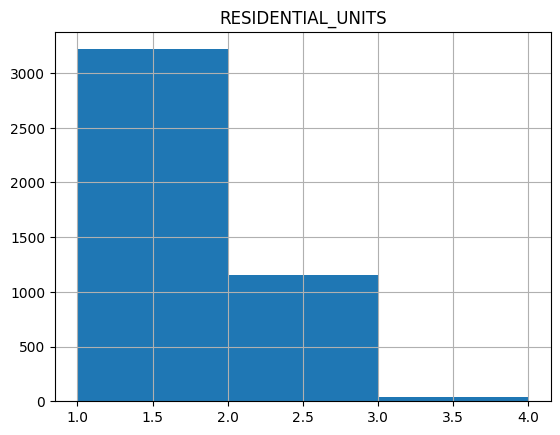

In [12]:
#stats on the number of residential units
REStaten_.hist('RESIDENTIAL_UNITS',bins=3)

Now look at the correlation between all the quantitative parameters of the properties

In [13]:
REStaten_[['YEAR_BUILT','RESIDENTIAL_UNITS','COMMERCIAL_UNITS','GROSS_SQUARE_FEET','LAND_SQUARE_FEET','SALE_PRICE']].corr()

,YEAR_BUILT,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,GROSS_SQUARE_FEET,LAND_SQUARE_FEET,SALE_PRICE
YEAR_BUILT,1.000000,-0.009658,-0.054582,0.141006,-0.220481,0.206584
RESIDENTIAL_UNITS,-0.009658,1.000000,-0.009424,0.383982,0.110894,0.245418
COMMERCIAL_UNITS,-0.054582,-0.009424,1.000000,0.067633,0.067733,0.005392
GROSS_SQUARE_FEET,0.141006,0.383982,0.067633,1.000000,0.464357,0.640454
LAND_SQUARE_FEET,-0.220481,0.110894,0.067733,0.464357,1.000000,0.521999
SALE_PRICE,0.206584,0.245418,0.005392,0.640454,0.521999,1.000000


Size, land area appear to demonstrate the strongest correlations trailed by the number of residential units

Perform a uni-variate linear regression on the feature showing the strongest correlation - the size


In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
#fit the regression without intercept
lm = LinearRegression(fit_intercept=False).fit(REStaten_[['GROSS_SQUARE_FEET']], REStaten_['SALE_PRICE'])

In [16]:
#slope coefficient
lm.coef_

array([317.72592299])

In [17]:
#fit regression with intercept
lm = LinearRegression(fit_intercept=True).fit(REStaten_[['GROSS_SQUARE_FEET']], REStaten_['SALE_PRICE'])
lm.coef_, lm.intercept_

(array([198.55835005]), 243296.25750452286)

In [18]:
print('Price~{}*Size+{}'.format(lm.coef_[0],lm.intercept_))

Price~198.55835004513676*Size+243296.25750452286


In [19]:
#alternative implementation with formulae
lm = smf.ols(formula='SALE_PRICE~GROSS_SQUARE_FEET', data = REStaten_).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             SALE_PRICE   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     3070.
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:29:05   Log-Likelihood:                -59690.
No. Observations:                4416   AIC:                         1.194e+05
Df Residuals:                    4414   BIC:                         1.194e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.433e+05   6694.58

Now standardize the sale_price and gross_square_feet by subtracting averages and dividing by standard deviation
Repeat the regression. Compare the regression coefficient against the correlation between sale_price and gross_square_feet. Do you find smth interesting here? Does the slope coefficient remind you something?

In [20]:
REStaten_['PRICE_stand']=(REStaten_['SALE_PRICE']-REStaten_['SALE_PRICE'].mean())/REStaten_['SALE_PRICE'].std()

In [22]:
REStaten_['SIZE_stand']=(REStaten_['GROSS_SQUARE_FEET']-REStaten_['GROSS_SQUARE_FEET'].mean())/REStaten_['GROSS_SQUARE_FEET']

In [23]:
#alternative implementation with formulae (-1 stands for no intercept as it inclused one by default)
lm = smf.ols(formula='PRICE_stand~SIZE_stand-1', data = REStaten_).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:            PRICE_stand   R-squared (uncentered):                   0.242
Model:                            OLS   Adj. R-squared (uncentered):              0.242
Method:                 Least Squares   F-statistic:                              1408.
Date:                Mon, 11 Nov 2024   Prob (F-statistic):                   1.01e-267
Time:                        14:30:39   Log-Likelihood:                         -5654.3
No. Observations:                4416   AIC:                                  1.131e+04
Df Residuals:                    4415   BIC:                                  1.132e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [24]:
#as we see the coefficient is exactly the correlation coefficient between the Price and Size
corrXY = np.corrcoef(REStaten_['SALE_PRICE'],REStaten_['GROSS_SQUARE_FEET'])[0,1]; corrXY

0.6404539846221196

In [25]:
#and the R-squared is exactly the square of the correlation coefficient
corrXY**2

0.41018130641835016

In [26]:
lm.rsquared

0.24180527975281907

In [27]:
#reconstruct original scale regression using the standardized regression
muX = REStaten_['GROSS_SQUARE_FEET'].mean(); muX

1709.1623641304348

In [28]:
sigmaX = REStaten_['GROSS_SQUARE_FEET'].std(); sigmaX

753.9046706673964

In [29]:
muY = REStaten_['SALE_PRICE'].mean(); muY

582664.7164855072

In [30]:
sigmaY = REStaten_['SALE_PRICE'].std(); sigmaY

233731.18302537053

In [31]:
w1 = sigmaY * corrXY / sigmaX; w1

198.5583500451368

In [32]:
w0 = muY - sigmaY * corrXY * muX / sigmaX; w0

243296.2575045228

In [33]:
#now compare with the original non-standardised regression
lm = smf.ols(formula='SALE_PRICE~GROSS_SQUARE_FEET', data = REStaten_).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             SALE_PRICE   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     3070.
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:33:17   Log-Likelihood:                -59690.
No. Observations:                4416   AIC:                         1.194e+05
Df Residuals:                    4414   BIC:                         1.194e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.433e+05   6694.58

In [34]:
#also consider a regression without intercept
lm = smf.ols(formula='SALE_PRICE~GROSS_SQUARE_FEET-1', data = REStaten_).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:             SALE_PRICE   R-squared (uncentered):                   0.894
Model:                            OLS   Adj. R-squared (uncentered):              0.894
Method:                 Least Squares   F-statistic:                          3.716e+04
Date:                Mon, 11 Nov 2024   Prob (F-statistic):                        0.00
Time:                        14:33:33   Log-Likelihood:                         -60268.
No. Observations:                4416   AIC:                                  1.205e+05
Df Residuals:                    4415   BIC:                                  1.205e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [35]:
#perform regression on 100 subsamples
np.random.seed(2019)
W=[]
for i in range(0,100):
    df=REStaten_.sample(frac=0.7)
    lm = smf.ols(formula='SALE_PRICE~GROSS_SQUARE_FEET-1', data = df).fit()
    W+=[lm.params.GROSS_SQUARE_FEET]

In [36]:
#and report mean and standard deviations of the resulting slope coefficients
np.array(W).mean()

317.64825558819604

In [37]:
np.array(W).std()

1.804072710698564


but mind the fact that variance will actually depend on the sample sizes and there is no direct correspondence - it was coincidental that the std of our experiments matched standard error reported in the regression summary. Those are different concepts. This experiment is just an illustration of the idea. A more robust explanation of the confidence intervals of the fit will be provided later in the class

Visualizations might further give an idea on how does the regression perform


<Axes: xlabel='GROSS_SQUARE_FEET', ylabel='SALE_PRICE'>

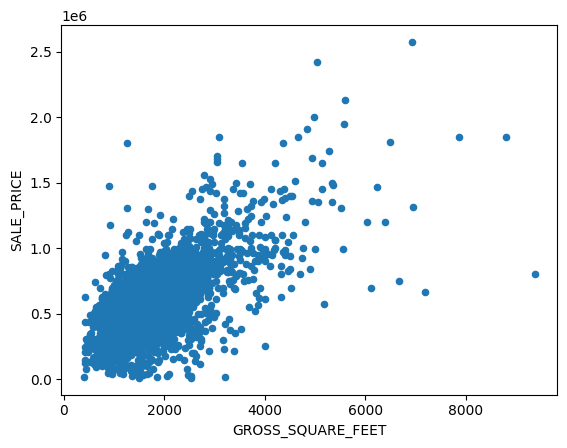

In [38]:
#first visualize the data
REStaten_.plot(x='GROSS_SQUARE_FEET',y='SALE_PRICE',kind='scatter')

In [39]:
#obtain values predicted by the regression
lm = smf.ols(formula='SALE_PRICE~GROSS_SQUARE_FEET', data = REStaten_).fit()
REStaten_['predicted_price']=lm.predict()

In [40]:
REStaten_[['SALE_PRICE','predicted_price']].head()

,SALE_PRICE,predicted_price
1,1650000,946192.816664
2,775000,808790.438433
3,685000,680124.627604
6,620000,393406.370139
8,1221900,799259.637631


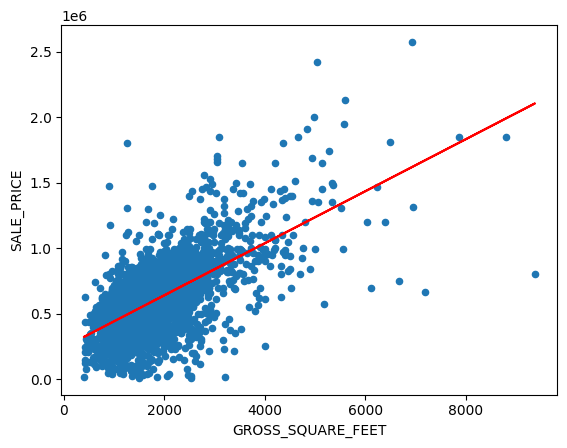

In [41]:
#add the prediction line
fig, ax = plt.subplots() #get axis to plot on
REStaten_.plot(ax=ax,kind='scatter',x='GROSS_SQUARE_FEET', y='SALE_PRICE') #show the data
ax.plot(REStaten_['GROSS_SQUARE_FEET'],REStaten_['predicted_price'],'r-'); #show the regression line

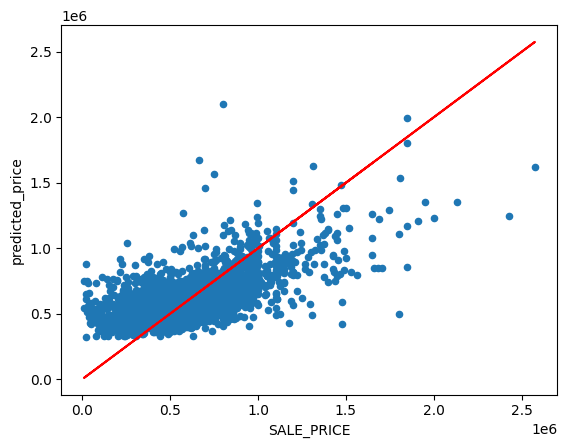

In [42]:
#another way visualize: actual values vs predicted values
fig, ax = plt.subplots() #get axis to plot on
REStaten_.plot(ax=ax,kind='scatter',x='SALE_PRICE', y='predicted_price') #show the data
ax.plot(REStaten_['SALE_PRICE'],REStaten_['SALE_PRICE'],'r-'); #show the regression line


Homework task 1. Perform regressions on the remaining regressors:

LAND_SQUARE_FEET,YEAR_BUILT,RESIDENTIAL_UNITS,COMMERCIAL_UNITS, with intercept. Visualize the regression fit for each of those as above

Report results (together with those for GROSS_SQ_FEET) in a data frame with the following columns: slope | intercept | R2, having regressor names as index. R-squared could be obtained through lm.rsquared


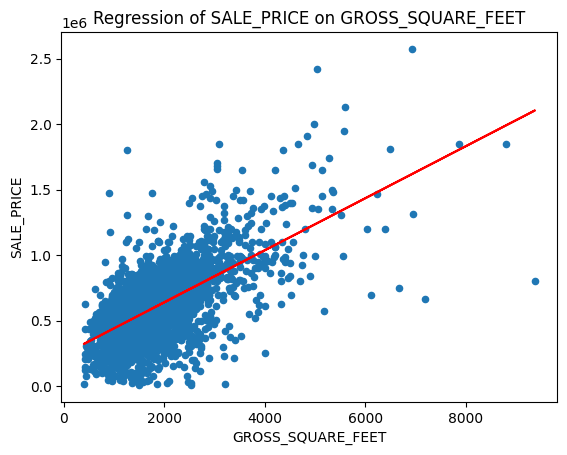

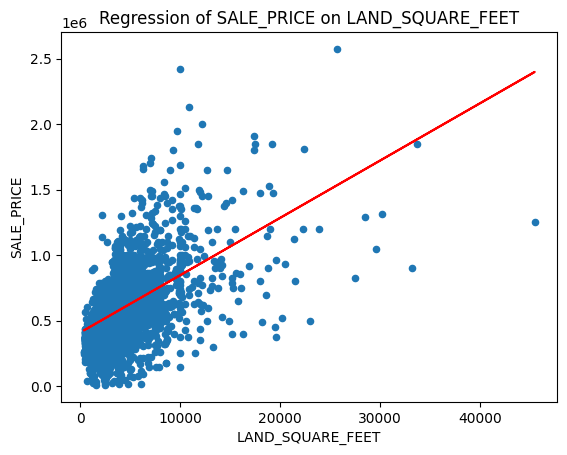

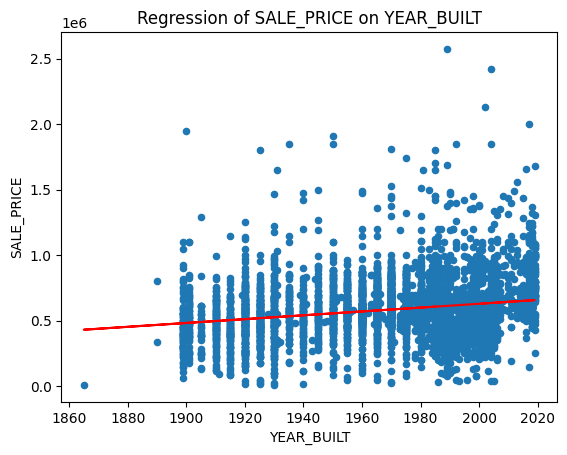

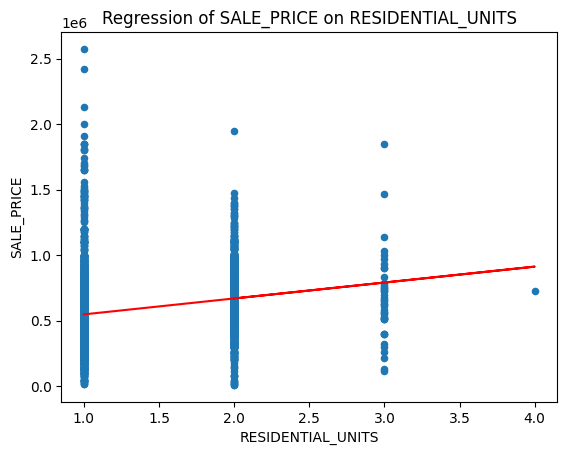

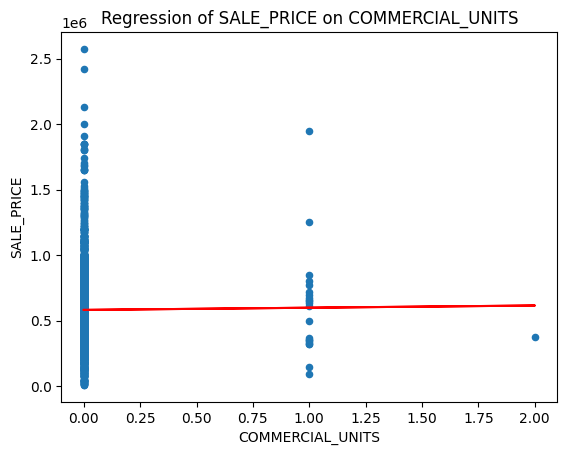

,slope,intercept,R2
GROSS_SQUARE_FEET,198.558350,2.432963e+05,0.410181
LAND_SQUARE_FEET,43.769710,4.105265e+05,0.272483
YEAR_BUILT,1467.017849,-2.304453e+06,0.042677
RESIDENTIAL_UNITS,121558.324664,4.268906e+05,0.060230
COMMERCIAL_UNITS,16788.907683,5.825773e+05,0.000029


In [45]:
# Perform regressions for the remaining regressors
regressors = ['LAND_SQUARE_FEET', 'YEAR_BUILT', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS']
results = {'slope': [], 'intercept': [], 'R2': []}

for regressor in regressors:
  lm = smf.ols(formula=f'SALE_PRICE~{regressor}', data=REStaten_).fit()
  results['slope'].append(lm.params[regressor])
  results['intercept'].append(lm.params['Intercept'])
  results['R2'].append(lm.rsquared)

# Include results for GROSS_SQUARE_FEET
lm = smf.ols(formula='SALE_PRICE~GROSS_SQUARE_FEET', data=REStaten_).fit()
results['slope'].insert(0, lm.params['GROSS_SQUARE_FEET'])
results['intercept'].insert(0, lm.params['Intercept'])
results['R2'].insert(0, lm.rsquared)

regressors.insert(0, 'GROSS_SQUARE_FEET')
results_df = pd.DataFrame(results, index=regressors)

# Visualize the regression fit for each regressor
for regressor in regressors:
  lm = smf.ols(formula=f'SALE_PRICE~{regressor}', data=REStaten_).fit()
  REStaten_['predicted_price'] = lm.predict()

  fig, ax = plt.subplots()
  REStaten_.plot(ax=ax, kind='scatter', x=regressor, y='SALE_PRICE')
  ax.plot(REStaten_[regressor], REStaten_['predicted_price'], 'r-')
  plt.title(f'Regression of SALE_PRICE on {regressor}')
  plt.show()

# Print the results DataFrame
results_df


Multi-variate regression case

Now try multivariate regression on GROSS_SQUARE_FEET+LAND_SQUARE_FEET+YEAR_BUILT together

In [46]:
lm = smf.ols(formula='SALE_PRICE~GROSS_SQUARE_FEET+LAND_SQUARE_FEET+YEAR_BUILT', data = REStaten_).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             SALE_PRICE   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     1589.
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:42:19   Log-Likelihood:                -59238.
No. Observations:                4416   AIC:                         1.185e+05
Df Residuals:                    4412   BIC:                         1.185e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.933e+06   1.55e+0

Now try multivariate regression on RESIDENTIAL_UNITS+COMMERCIAL_UNITS together

In [47]:
lm = smf.ols(formula='SALE_PRICE~RESIDENTIAL_UNITS+COMMERCIAL_UNITS', data = REStaten_).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             SALE_PRICE   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     141.6
Date:                Mon, 11 Nov 2024   Prob (F-statistic):           2.58e-60
Time:                        14:43:06   Log-Likelihood:                -60719.
No. Observations:                4416   AIC:                         1.214e+05
Df Residuals:                    4413   BIC:                         1.215e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.267e+05   9875.49

In [48]:
lm = smf.ols(formula='SALE_PRICE~GROSS_SQUARE_FEET+LAND_SQUARE_FEET+YEAR_BUILT+RESIDENTIAL_UNITS+COMMERCIAL_UNITS', data = REStaten_).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             SALE_PRICE   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     964.6
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:43:21   Log-Likelihood:                -59224.
No. Observations:                4416   AIC:                         1.185e+05
Df Residuals:                    4410   BIC:                         1.185e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.987e+06   1.57e+0

In [54]:
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['samples', 'GROSS_SQUARE_FEET_coef', 'LAND_SQUARE_FEET_coef', 'YEAR_BUILT_coef', 'Intercept', 'R2'])

# Define the residential unit categories and corresponding filter conditions
residential_categories = {
    1: REStaten_['RESIDENTIAL_UNITS'] == 1,
    2: REStaten_['RESIDENTIAL_UNITS'] == 2,
    '3+': REStaten_['RESIDENTIAL_UNITS'] >= 3
}

# Loop through each residential unit category
for residential_units, condition in residential_categories.items():
  # Filter the data based on the current residential unit category and COMMERCIAL_UNITS==0
  subset_data = REStaten_.loc[condition & (REStaten_['COMMERCIAL_UNITS'] == 0)]

  # Perform the regression analysis on the subset
  lm = smf.ols(formula='SALE_PRICE~GROSS_SQUARE_FEET+LAND_SQUARE_FEET+YEAR_BUILT', data=subset_data).fit()

  # Extract the relevant information and store it in the results DataFrame
  results_df.loc[residential_units] = [
      len(subset_data),
      lm.params['GROSS_SQUARE_FEET'],
      lm.params['LAND_SQUARE_FEET'],
      lm.params['YEAR_BUILT'],
      lm.params['Intercept'],
      lm.rsquared
  ]

# Display the results DataFrame
results_df

,samples,GROSS_SQUARE_FEET_coef,LAND_SQUARE_FEET_coef,YEAR_BUILT_coef,Intercept,R2
1,3200.0,139.387163,30.558815,1134.016234,-2.012218e+06,0.526892
2,1151.0,113.883675,31.076155,2517.044042,-4.662861e+06,0.433946
3+,43.0,29.529114,51.992945,2381.431181,-4.258056e+06,0.529637
